In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import os

In [201]:
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
FileName = "2024_07_09_11_30_174.jpg"
raw_img = cv.imread(Directory + "/" + FileName)
img = cv.cvtColor(raw_img, cv.COLOR_BGR2GRAY)
img = raw_img

In [123]:
model = YOLO('best.pt', task='segment')

In [203]:
model = YOLO('best.pt')
results = model(img, conf=0.3, save=True, show_labels=False, retina_masks=True)


0: 544x640 4 Fire-Smoke-Sodium-Trays, 5337.9ms
Speed: 44.0ms preprocess, 5337.9ms inference, 23.0ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs\segment\predict7


**Pre and Post processing time**
- reduced from 5 seconds to ms by resizing the image before applying to the model

In [214]:
test = np.array(results[0].masks[:].data)

In [217]:
np.logical_or(test,axis=0)

TypeError: logical_or() takes from 2 to 3 positional arguments but 1 were given

(576, 704)

In [220]:
for i in range(4):
    print(np.count_nonzero(test[i,:,:]))

1906
884
4500
297


# Transform Model to Onnx

In [52]:
model.export(format="onnx")  # creates 'yolov8n_openvino_model/

Ultralytics YOLOv8.0.196  Python-3.11.5 torch-2.2.2 CPU (Intel Core(TM) i5         680  3.60GHz)

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 38, 8400), (1, 32, 160, 160)) (52.3 MB)
requirements: Ultralytics requirement ['onnxsim>=0.4.33'] not found, attempting AutoUpdate...
requirements:  AutoUpdate skipped (offline)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: simplifier failure: No module named 'onnxsim'
ONNX: export success  24.4s, saved as 'best.onnx' (104.1 MB)

Export complete (35.6s)
Results saved to C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal
Predict:         yolo predict task=segment model=best.onnx imgsz=640  
Validate:        yolo val task=segment model=best.onnx imgsz=640 data=/content/datasets/Sodium-Disposal-2/data.yaml  
Visualize:       https://netron.app


'best.onnx'

In [53]:
onnx_model = YOLO("best.onnx", task='segment')

In [55]:
res_onnx = onnx_model(img, conf=0.3)


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3283.0ms
Speed: 8.0ms preprocess, 3283.0ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)


## ONNX Model Optimizations

### F32 to F16

In [19]:
import onnx
from onnxconverter_common import float16

In [22]:
onnx_model = onnx.load("best.onnx")
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model)
onnx.save(onnx_model_fp16, "model_fp16.onnx")

In [25]:
onnx_model = YOLO("model_fp16.onnx", task='segment')

In [ ]:
res_onnx_fp16 = onnx_model(img, conf=0.3)

In [30]:
img.dtype

dtype('uint8')

# Transform Model to OpenVino

In [ ]:
model.export(format="openvino")  # creates 'yolov8n_openvino_model/

In [ ]:
ov_model = YOLO("yolov8n_openvino_model/")

# Run inference
results = ov_model("https://ultralytics.com/images/bus.jpg")

# Video Inferencing

In [58]:
from ultralytics.utils.plotting import Annotator, colors

In [228]:
count_frame = 0
fps = 15
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
width = height = 640
Files = os.listdir(Directory)

In [229]:
model = YOLO('best.pt')
out = cv.VideoWriter("instance-segmentation-object-tracking.avi", cv.VideoWriter_fourcc(*"MJPG"), fps, (width, height))
video = cv.VideoCapture(r"F:\Work\SOCAAutomation\Dataset\NA_DISOPSAL_SOCA_2024\09072024\AXIS 213 - 10.1.5.173 2024-07-09_11_30_00_000.asf")
dur = [[3,0], [3,45]] #[mins,secs]
startFrame = (dur[0][0] * 60 + dur[0][1] ) * fps
endFrame = (dur[1][0] * 60 + dur[1][1] ) * fps

In [230]:
while True:
    ret, frame = video.read()
    if ret:
        if count_frame > 10 and count_frame < 20:
            img_resize = cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
            results = model(img_resize, conf=0.3)
            if results[0].masks is not None:
                mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
                orig_img = img_resize #results[0].orig_img
                mask_img_3 = np.stack([mask_img, np.zeros(mask_img.shape), np.zeros(mask_img.shape)], axis=2)
                mask_inv = np.logical_not(np.stack([mask_img, mask_img, mask_img], axis=2))
                temp_image = np.zeros(orig_img.shape)
                temp_image = mask_inv * orig_img
                temp_image += (mask_img_3 * 255).astype('uint8')
            else:
                temp_image = img_resize

            out.write(temp_image)

        count_frame += 1
    else:
        break
out.release()
video.release()


0: 640x640 3 Fires, 3940.6ms
Speed: 6.0ms preprocess, 3940.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 3850.5ms
Speed: 7.0ms preprocess, 3850.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


TypeError: 'NoneType' object is not subscriptable

In [225]:
for i in range(10):    
    FileName = Files[i]
    raw_img = cv.imread(Directory + "/" + FileName)
    img_resize = cv.resize(raw_img, (width, height), interpolation = cv.INTER_LINEAR)
    results = model(img_resize, conf=0.3)
    mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
    orig_img = img_resize #results[0].orig_img
    mask_img_3 = np.stack([mask_img, np.zeros(mask_img.shape), np.zeros(mask_img.shape)], axis=2)
    mask_inv = np.logical_not(np.stack([mask_img, mask_img, mask_img], axis=2))
    temp_image = np.zeros(orig_img.shape)
    temp_image = mask_inv * orig_img
    temp_image += (mask_img_3 * 255).astype('uint8')
            
    out.write(temp_image)

out.release()


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4129.8ms
Speed: 7.0ms preprocess, 4129.8ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3919.5ms
Speed: 7.0ms preprocess, 3919.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 3648.3ms
Speed: 7.0ms preprocess, 3648.3ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 3642.3ms
Speed: 7.0ms preprocess, 3642.3ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 4614.2ms
Speed: 8.0ms preprocess, 4614.2ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 3755.4ms
Speed: 7.0ms preprocess, 3755.4ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 3723.4ms
Speed: 7.0ms preprocess, 3723.4ms inference, 18.0ms postprocess per 

In [233]:
len(results[0].masks)

TypeError: object of type 'NoneType' has no len()

In [124]:
results = model(img, conf=0.3, save=True)


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3979.6ms
Speed: 8.0ms preprocess, 3979.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict6


In [118]:
ind_arr = (results[0].masks.xy[1]).astype('uint8')

In [119]:
ind_arr

array([[ 59, 144],
       [ 58, 145],
       [ 56, 145],
       [ 55, 146],
       [ 55, 147],
       [ 54, 148],
       [ 54, 149],
       [ 53, 150],
       [ 51, 150],
       [ 50, 151],
       [ 49, 151],
       [ 49, 152],
       [ 48, 153],
       [ 48, 166],
       [ 49, 167],
       [ 50, 167],
       [ 52, 169],
       [ 52, 170],
       [ 53, 171],
       [ 54, 171],
       [ 55, 172],
       [ 57, 172],
       [ 59, 174],
       [ 60, 174],
       [ 61, 175],
       [ 70, 175],
       [ 74, 171],
       [ 78, 171],
       [ 79, 170],
       [ 79, 169],
       [ 81, 167],
       [ 82, 167],
       [ 83, 166],
       [ 83, 154],
       [ 80, 151],
       [ 79, 151],
       [ 74, 146],
       [ 74, 145],
       [ 72, 145],
       [ 71, 144]], dtype=uint8)

In [113]:
test = results[0].orig_img

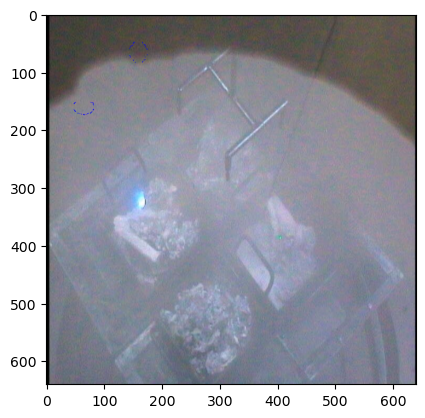

In [120]:
test[list(ind_arr[:,0]), list(ind_arr[:,1]), 0] = 0
test[ind_arr[:,0], ind_arr[:,1], 1] = 0
test[ind_arr[:,0], ind_arr[:,1], 2] = 255
plt.imshow(test)

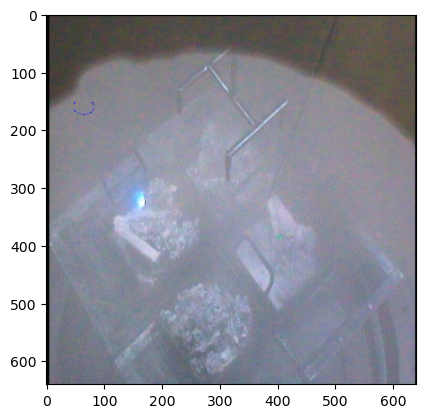

In [115]:
plt.imshow(img_resize)

In [117]:
len(results[0].masks.xy)

2

In [121]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'Fire', 1: 'Fire-Smoke-Sodium-Tray'}
 orig_img: array([[[  0,   5,   0],
         [  0,   5,   0],
         [  0,   6,   0],
         ...,
         [ 99,  99,  81],
         [ 47,  47,  31],
         [ 10,  10,   1]],
 
        [[  0,   6,   1],
         [  0,   6,   0],
         [  1,   6,   1],
         ...,
         [ 98,  98,  80],
         [ 46,  46,  30],
         [ 10,  10,   1]],
 
        [[  1,   5,   2],
         [  1,   5,   0],
         [  2,   6,   3],
         ...,
         [ 99,  97,  79],
         [ 47,  45,  29],
         [ 11,   9,   1]],
 
        ...,
 
        [[  0,   4,   3],
         [  0,   2,   0],
         [  0,   2,   1],
         ...,
         [142, 147, 151],
         [ 54,  60,  63],
         [  2,   6,   8]],
 
        [[  2,   4,   4],
         [  0,   1,   1],
       

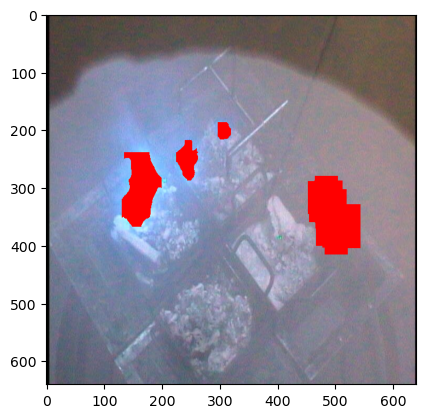

In [223]:
plt.imshow(temp_image)


In [186]:
cv.imshow('window', temp_image)
cv.waitKey()

-1

In [187]:
([mask_img] * 3).shape

AttributeError: 'list' object has no attribute 'shape'